In [1]:
import pandas as pd
import numpy as np
import jieba,re,os
import jieba.posseg as pseg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/summer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
train_data1 = pd.read_csv('/Users/summer/Documents/OriginalDataSet.csv', encoding='UTF-8')[['multi','text','user_verified', 'user_description', 'user_gender', 'user_messages', 'user_followers', 'user_location', 'user_time', 'user_friends', 'has_url', 'comments', 'pics', 'likes', 'time', 'reposts', 'rumor','multi_type','user']]

In [6]:
train_data=train_data1[~train_data1['user'].isin(['empty'])] #删除user="empty"的行
train_data.loc[train_data['multi'].isnull(),'multi']=train_data[train_data['multi'].isnull()]['multi_type'] #当multi为空时用multi_type替代

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
label_dict = {"yes" : 1, "no" : 0}
print(label_dict)
train_data['rumor_id'] = train_data['rumor'].apply(lambda x: label_dict[x])

{'yes': 1, 'no': 0}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
col = ['rumor','text','rumor_id']
train_data = train_data[col]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
def proc_text(raw_line):
    """
        处理每行的文本数据
        返回分词结果
    """
    # 1. 使用正则表达式去除非中文字符
    filter_pattern = re.compile('[^\u4E00-\u9FD5]+')
    chinese_only = filter_pattern.sub('', raw_line)
    # 2. 结巴分词+词性标注
    words_lst = pseg.cut(chinese_only)
    # 3. 去除停用词
    meaninful_words = []
    for word, flag in words_lst:
        # if (word not in stopwords) and (flag == 'v'):
            # 也可根据词性去除非动词等
        if word not in stopwords:
            meaninful_words.append(word)
    return ' '.join(meaninful_words)

stopwords = [line.strip() for line in open('/Users/summer/Documents/stopword.txt', 'r', encoding='utf-8').readlines()]
# df_label = train_data['rumor']
train_data['text'] = train_data['text'].apply(proc_text)

train_data = train_data[train_data['text'] != '']

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords)

features = tfidf.fit_transform(train_data.text).toarray()

labels  = train_data.rumor_id
features.shape

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/pj/y730zhjs06dfj_s3fd_s5cp00000gn/T/jieba.cache
Loading model cost 0.897 seconds.
Prefix dict has been built succesfully.


(3297, 4656)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['rumor'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels , scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

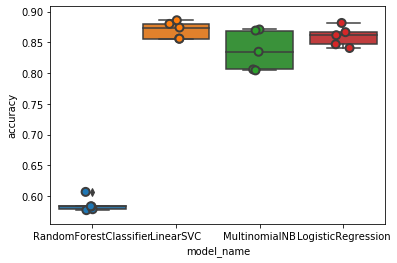

In [13]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.870501
LogisticRegression        0.859577
MultinomialNB             0.837154
RandomForestClassifier    0.585992
Name: accuracy, dtype: float64

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


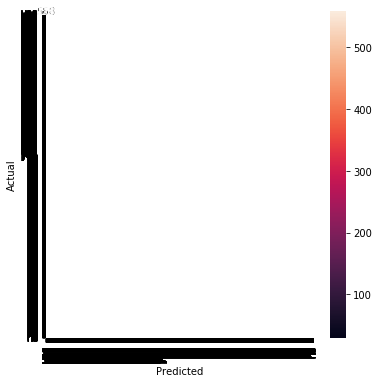

In [16]:
# 进一步研究模型性能
import matplotlib.pyplot as plt
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels , train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=train_data.rumor, yticklabels=train_data.rumor.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# 使用混淆矩阵查看预测分布情况（LogisticRegression）
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.set()
C2 = confusion_matrix(y_test, y_pred)
sns.heatmap(C2,annot=True,fmt='d')

In [17]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=train_data['rumor'].unique()))

              precision    recall  f1-score   support

         yes       0.81      0.95      0.88       588
          no       0.93      0.74      0.83       501

   micro avg       0.85      0.85      0.85      1089
   macro avg       0.87      0.85      0.85      1089
weighted avg       0.87      0.85      0.85      1089

